In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

pd.options.mode.chained_assignment = None  # default='warn'
import random

import seaborn as sns
import networkx as nx

In [2]:
# Enter filename(s) to initially merge into consolidated dataframe and then export for future use 
def create_merged_df():
    filename = ['1_30_member_list.csv','31-60_member_list.csv','61-100_member_list.csv',
                '101-200_member_list.csv', '201-400_member_list.csv', '401-700_member_list.csv',
                '701-1100_member_list.csv','1101-1300_member_list.csv','1301-1531_member_list.csv']

    raw_df = pd.DataFrame([])

    # Merge the files into the same dataframe for later analysis
    for file in filename:     
        tempdf = pd.read_csv(file, low_memory=False)
        tempdf = tempdf[['id','name','group_name','joined','topics']]
        raw_df = pd.concat([raw_df,tempdf],sort=False)

    raw_df.reset_index(drop=True,inplace=True)
    return raw_df

# Export consolidated dataframe
#raw_df = create_merged_df()

In [3]:
# Export consodilated dataframe to CSV for future loading
#raw_df.to_csv('cons_member_list.csv', index=False)

In [4]:
# Load consolidated dataframe
df = pd.read_csv('cons_member_list.csv')

In [5]:
# Create subset of member_df with only columns of interest
member_df = df.copy()
member_df = member_df[['id','name','group_name']]

In [6]:
# Remove groups manually which are not useful in the analysis
removed_groups = ['0dbfbe09-64eb-4807-bc43-3c4567f43d32']
member_df = member_df.loc[~member_df['group_name'].isin(removed_groups)]
member_df.reset_index(drop=True,inplace=True)

group_names = list(set(member_df['group_name']))

# Create Bipartite Graph and Projected Weighted Network

In [7]:
# Create Bipartite Graph between members and groups 
BiGraph = nx.Graph()
BiGraph.add_nodes_from(member_df['id'],bipartite = 'member_id')
BiGraph.add_nodes_from(member_df['group_name'],bipartite = 'group_name')
BiGraph.add_edges_from([(row['id'], row['group_name']) for idx, row in member_df.iterrows()])

# Print number of edges and number of unique members to examine graph
print("Number of Edges: ",len(BiGraph.edges(data=True)))
print("Number of Unique Members: ",len(set(member_df['id'])))

Number of Edges:  1275396
Number of Unique Members:  350869


In [8]:
# Identify members which are only part of one technology Meetup group
one_group_members = [a for (a,b) in BiGraph.nodes(data=True) if (b['bipartite'] == 'member_id') & (BiGraph.degree(a) == 1)]
loners = member_df.loc[member_df['id'].isin(one_group_members)]

# Determine the total number of "loner" members in each group and the proportion of loner members of total group members
loner_abs = loners['group_name'].value_counts()
loner_proportion = loners['group_name'].value_counts() / member_df['group_name'].value_counts().loc[loners['group_name'].value_counts().index]

# Create loner dataframe for later analysis
loner_df = pd.concat([loner_abs, loner_proportion],axis=1)
loner_df.reset_index(inplace=True)
loner_df.columns = ['group_name', 'abs_loners', 'prop_loners']

In [9]:
# Create projection of bipartite graph to analyze shared membership between groups
group_projection = nx.bipartite.weighted_projected_graph(BiGraph, group_names)

print("Number of Nodes: ",len(group_projection.nodes()))
print("Number of Edges: ",len(group_projection.edges()))

Number of Nodes:  1457
Number of Edges:  772495


In [10]:
# Create dataframe with projected network data

# First get number of members for each group
member_counts = member_df['group_name'].value_counts()

# Get the weight of the shared membership between groups
weights = nx.get_edge_attributes(group_projection,'weight')

# Create dataframe of list of names and member counts for each group
names = [[g1,g2] for g1, g2 in list(weights.keys())]
group_names = pd.DataFrame(names,columns=['group1','group2'])
member_count_list = [[member_counts.loc[g1],member_counts.loc[g2]] for g1, g2 in list(weights.keys())]
member_count_df = pd.concat([group_names,
                            pd.DataFrame(member_count_list,columns=['group1_members','group2_members'])],
                            axis=1)

# Need to edge weights for the number of members in each group therefore take the average of shared proportion
member_count_df['shared_members'] = list(weights.values())
prop1 = member_count_df['shared_members'] / member_count_df['group1_members']
prop2 = member_count_df['shared_members'] / member_count_df['group2_members']

# Simple average between groups 
member_count_df['bayes'] = (prop1+prop2)/2

# Show groups with highest shared overlap
member_count_df.sort_values(by='bayes',ascending=False)[:10]

,group1,group2,group1_members,group2_members,shared_members,bayes
103815,hoodlums,London-Haskell,595,1600,397,0.457676
384670,London-Javascript,London-JavaScript-Community,2210,7986,1495,0.431837
370542,NSLondon,swiftlondon,1832,3297,1002,0.425428
77814,Drupal-London-Communit,London-Drupal-Pub-Meet,350,1053,223,0.424459
149800,DevOps-Exchange-London,London-DevOps,6590,5928,2606,0.417528
194950,drupal-show-and-tell,London-Drupal-Pub-Meet,739,1053,350,0.402998
639628,agiletesting,UK-Test-Automation,4083,1193,744,0.402928
32609,LondonSalesforceDevelopers,London-Salesforce-Admins,2209,1721,779,0.402646
318091,instech,instechglobal,2267,113,85,0.394853
726598,sug-uk,Sitecore-8-bridging-the-gap-between-technology...,963,123,86,0.394246


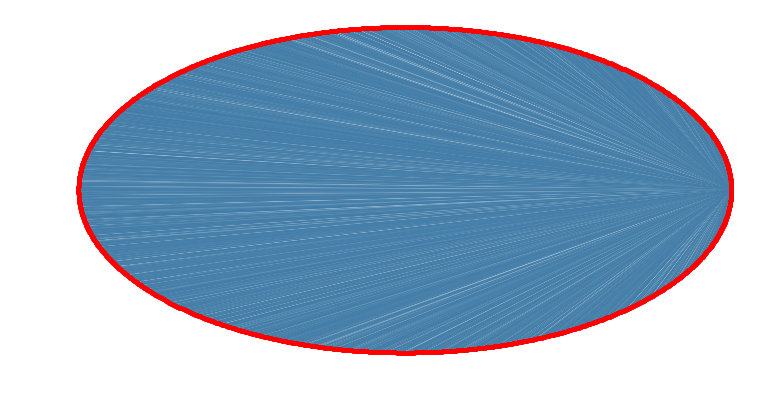

In [11]:
# Draw Circle layout colored edges to visualize graph although this is not scalable and does not work very effectively on even a random subset 
plt.figure(figsize=(10, 5))
cmap = sns.diverging_palette(240, 10, n=20, as_cmap=True)
pos = nx.circular_layout(group_projection)
# Randomly subset the graph for visualization. Was not used as is still not very informative
#sub_group_projection = group_projection.subgraph(random.sample(group_projection.nodes,50))

# Render visualization
nx.draw(group_projection,pos=pos,node_size=15,with_labels=False, font_size=8, edge_color=member_count_df['bayes'],edge_cmap=cmap)

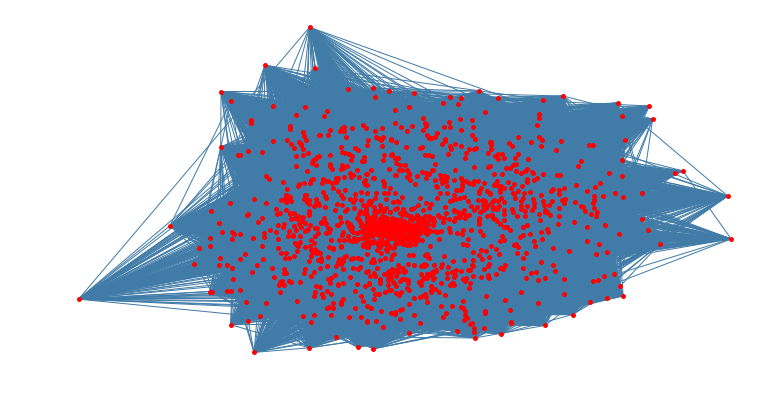

In [12]:
# Draw network with Spring layout with colored edges
plt.figure(figsize=(10, 5))
weights = nx.get_edge_attributes(group_projection,'weight')
cmap = sns.diverging_palette(240, 10, as_cmap=True)
pos = nx.spring_layout(group_projection)
nx.draw(group_projection,pos=pos,node_size=15,with_labels=False, font_size=8,edge_color=list(weights.values()),edge_cmap=cmap)
#nx.draw_networkx_edge_labels(group_projection,pos=pos,node_size=15,with_labels=False, font_size=8,edge_labels=weights);

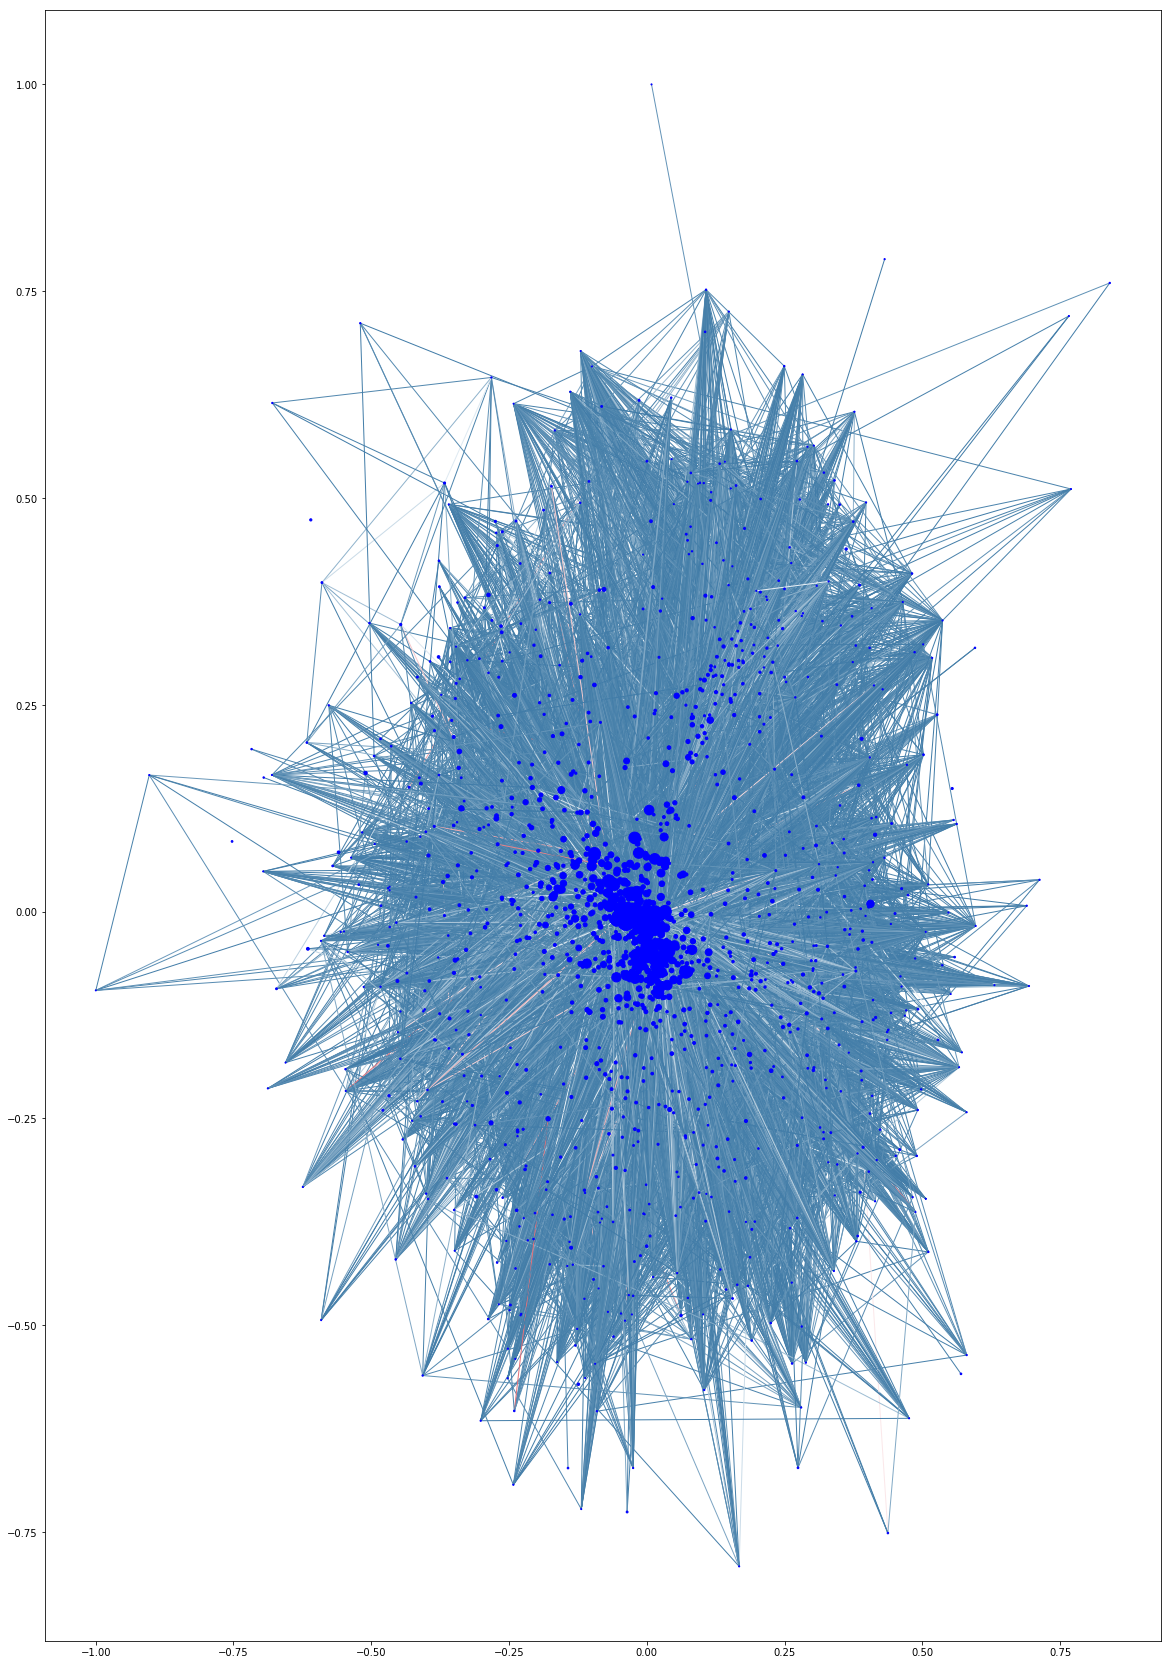

In [13]:
# Enlarge spring layout graph to see only edges above the 90th percentile of shared members
plt.figure(figsize=(20, 30))
cmap = sns.diverging_palette(240, 10, n=20, as_cmap=True)
pos = nx.spring_layout(group_projection)
node_size = [member_counts.loc[group]/50 for group in group_projection.nodes()]
labels = [name for name in group_projection.nodes()]

threshold = np.percentile(member_count_df['bayes'],90)
threshold_edgelist = [groups for idx, groups in enumerate(group_projection.edges()) if (member_count_df['bayes'].iloc[idx] >= threshold)]
edge_color = member_count_df['bayes'].loc[member_count_df['bayes'] >= threshold]

nx.draw_networkx_nodes(group_projection,pos=pos, node_size=node_size, node_color='b');
nx.draw_networkx_edges(group_projection,pos=pos, edgelist=threshold_edgelist, edge_color=edge_color, edge_cmap=cmap);

#nx.draw_networkx_labels(group_projection, pos=pos, font_size=8);

In [14]:
# Export edge list and loner df for later modelling
def export_model_outputs():
    member_count_df.to_csv('projected_graph_edgelist.csv', index=False)
    loner_df.to_csv('loner_df.csv',index=False)

#export_model_outputs()

# Create kmeans clusters and MDS positions

In [7]:
# Create kmeans clusters from relationship data, can augment using membership overlap between groups 

# Import / instantiate networkx graph
edgelist_df = pd.read_csv('projected_graph_edgelist.csv')
edgelist_df = edgelist_df[['group1','group2','bayes']]
edgelist_df.columns = ['source', 'target', 'weight']

G = nx.from_pandas_edgelist(edgelist_df,edge_attr=True)
adj_matrix = nx.convert_matrix.to_pandas_adjacency(G)

In [8]:
from sklearn.cluster import KMeans
# Define number of K-means clusters
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=34).fit(adj_matrix)
kmeans_cluster = kmeans.labels_

cluster_index = pd.DataFrame(kmeans_cluster,columns=['kmeans_cluster'], index=adj_matrix.index)

In [89]:
from sklearn.manifold import MDS
# Use multidimensional scaling to capture similarity between groups and return positions in 2d space 
mds = MDS(n_components=2);
mds_weights = mds.fit_transform(adj_matrix);

positions = {key: value for (key, value) in zip(adj_matrix.index, mds_weights)}

C:\Users\annie\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


In [90]:
# Save position weights for upload to Bokeh Graphview
#np.save('position_weights.npy', positions)

In [114]:
from collections import Counter
from bokeh.palettes import Category20
color_palette = Category20[n_clusters]

# Count number of members
member_count = dict(Counter(member_df['group_name']))
node_size = [min(member_count[group]/200,20) for group in list(G.nodes())]

# Color nodes
node_color = [color_palette[i] for i in kmeans_cluster]
member_count = [member_count[i] for i in adj_matrix.index]

degree_dict = dict(G.degree(weight='weight'))

# Save closeness centrality as takes a long time to compute
#closeness_dict = nx.closeness_centrality(G)
#np.save('closeness_centrality.npy', closeness_dict)

closeness_dict = np.load('closeness_centrality.npy').item()
mean_closeness_centrality = np.array(list(closeness_dict.values())).mean()
rel_closeness_centrality = np.array(list(closeness_dict.values())) / mean_closeness_centrality -1

node_data = pd.DataFrame({'group_name':adj_matrix.index, 'member_count':member_count, 'node_size':node_size,
                          'node_color':node_color, 'kcluster':kmeans_cluster, 'degree_centrality':list(degree_dict.values()),
                          'rel_closeness_centrality':rel_closeness_centrality})

In [119]:
# Export node list for Bokeh Graphview
node_data.to_csv('projected_graph_nodelist.csv',index=False)

In [120]:
# Examine data
node_data.head()

,group_name,member_count,node_size,node_color,kcluster,degree_centrality,rel_closeness_centrality
0,Future-of-Media-Publishing-London,473,2.365,#ffbb78,3,5.496012,-0.095803
1,AgileWomenUK,520,2.600,#2ca02c,4,12.447759,-0.060216
2,grakn-london,1494,7.470,#c5b0d5,9,35.721313,0.196258
3,Contain,510,2.550,#9467bd,8,22.667266,0.022955
4,London-Growth-Hackers,1097,5.485,#1f77b4,0,17.870567,0.081480


# Feature Engineering

In [2]:
# Load consolidated dataframe
df = pd.read_csv('cons_member_list.csv')

In [3]:
# Take sample of df to improve computational speed 
df = df.sample(frac=0.1, random_state=34)

In [4]:
member_df = df[['id','name','topics']].drop_duplicates(subset=['id'])

In [5]:
import gender_guesser.detector as gender

# First get first name
first_name = [name.split()[0].capitalize() if type(name) == str else 'Unknown' for name in member_df['name']]

# Then detect gender
gender_detector = gender.Detector()
gender = [gender_detector.get_gender(name) for name in first_name]

# Aggregate classifications which aren't helpful
gender_map = {'andy':'unknown_gender','mostly_male':'male','mostly_female':'female', 'unknown':'unknown_gender'}

gender_df = pd.DataFrame(gender,columns=['gender'],index=member_df.index).replace(gender_map)

member_df = member_df.join(pd.get_dummies(gender_df['gender']))

In [6]:
# Add features related to date joined, groups, and number of groups
date_joined = []
groups = []
num_groups = []

for member_id in member_df['id']:
    temp_df = df['id'] == member_id
    temp_date_joined = min(df['joined'].loc[temp_df].values)
    temp_groups = df['group_name'].loc[temp_df].values
    temp_num_groups = len(temp_groups)
    
    date_joined.append(temp_date_joined)
    groups.append(temp_groups)
    num_groups.append(temp_num_groups)

member_df['joined'] = date_joined
member_df['groups'] = groups
member_df['num_groups'] = num_groups

member_df.dropna(subset=['joined'],inplace=True)
member_df.reset_index(drop=True,inplace=True)

In [7]:
# Create feature out of number of days member has joined one of the groups
from datetime import datetime
member_df['member_duration'] = [(datetime(2018,12,5) - datetime.fromtimestamp(member_df['joined'].iloc[i]/1000)).days
                                for i in range(len(member_df))]

In [8]:
# Create kmeans clusters from relationship data, can augment using membership overlap between groups 

# Import / instantiate networkx graph
edgelist_df = pd.read_csv('projected_graph_edgelist.csv')
edgelist_df = edgelist_df[['group1','group2','bayes']]
edgelist_df.columns = ['source', 'target', 'weight']

G = nx.from_pandas_edgelist(edgelist_df,edge_attr=True)
adj_matrix = nx.convert_matrix.to_pandas_adjacency(G)

In [9]:
from sklearn.cluster import KMeans
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=34).fit(adj_matrix)
kmeans_cluster = kmeans.labels_

cluster_index = pd.DataFrame(kmeans_cluster,columns=['kmeans_cluster'], index=adj_matrix.index)

cluster_index['kmeans_cluster'].value_counts()

3    536
0    302
1    133
5    130
9    126
8     55
6     53
7     44
4     44
2     34
Name: kmeans_cluster, dtype: int64

In [10]:
# Identify removed groups
removed_groups = ['0dbfbe09-64eb-4807-bc43-3c4567f43d32']

kmeans_clusters_list = [[cluster_index.loc[group].item() for group in groups if group not in removed_groups] for groups in member_df['groups']]

In [11]:
from collections import Counter
kmeans_dict = [Counter(clusters_list) for clusters_list in kmeans_clusters_list]
kmeans_df = pd.DataFrame(kmeans_dict,index=member_df.index).fillna(0)
kmeans_df.columns = ['kcluster_'+str(i) for i in range(n_clusters)]
kmeans_df = kmeans_df.div(member_df['num_groups'],axis=0)

member_df = member_df.join(kmeans_df)

In [12]:
# Select target group to predict membership in
target_group = 'Data-Science-London'
member_df['member_of_group'] = [1 if target_group in groups else 0 for groups in member_df['groups']]

In [13]:
member_df.head()

,id,name,topics,female,male,unknown_gender,joined,groups,num_groups,member_duration,...,kcluster_1,kcluster_2,kcluster_3,kcluster_4,kcluster_5,kcluster_6,kcluster_7,kcluster_8,kcluster_9,member_of_group
0,185558321.0,Anna,"[{'urlkey': 'art', 'name': 'Art', 'id': 1502},...",1,0,0,1.427320e+12,[ShoreditchJS],1,1350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,39430332.0,Dominik Widomski,"[{'urlkey': 'digcam', 'name': 'Digital Photogr...",0,1,0,1.495711e+12,[London-Startup-Growth-Meetup],1,558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,37477352.0,Robert,[],0,1,0,1.490221e+12,"[Fashion-Tech-Global, Digital-Product-London, ...",10,622,...,0.0,0.0,0.6,0.0,0.0,0.0,0.2,0.0,0.0,0
3,187567042.0,Adam Travers,"[{'urlkey': 'art', 'name': 'Art', 'id': 1502},...",0,1,0,1.482251e+12,[MinistryOfTesting],1,714,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,223510983.0,Lefteris,[],0,0,1,1.497639e+12,[London-GameDev-Lunch],1,536,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [14]:
prediction_df = member_df.copy()
prediction_df.drop(['joined','groups','name','id','topics'],axis=1,inplace=True)

# Exploratory Data Analysis

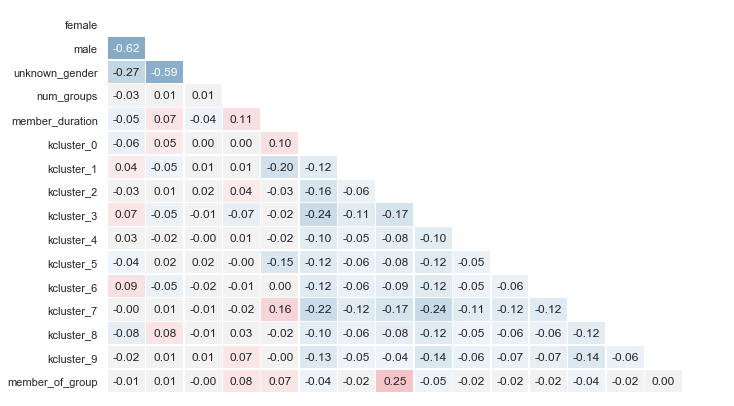

In [142]:
# Create correlation heatmap of important features and target
    # [https://seaborn.pydata.org/examples/many_pairwise_correlations.html]
sns.set(style="white")
corr_feats = prediction_df.copy()

# Compute the correlation matrix
corr = corr_feats.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=False, linewidths=.5, annot=True, fmt=".2f", cbar=False, yticklabels = True, xticklabels = False);

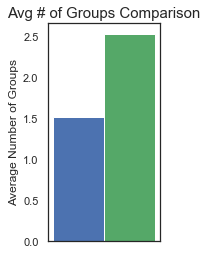

In [143]:
# Plot bar chart comparison between features given target 
plt.figure(figsize=(2, 4))
width = .08

selected_feature = 'num_groups'
feature_means = prediction_df.groupby(
    'member_of_group').mean().transpose().round(2).iloc[:5,:].loc[selected_feature]

plt.bar(1,feature_means[0], width=width,color='b')
plt.bar(1+width,feature_means[1], width=width, color = 'g')
plt.xticks(range(1), selected_feature);
plt.ylabel('Average Number of Groups')
plt.title('Avg # of Groups Comparison',size=15);

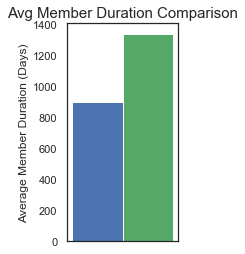

In [144]:
plt.figure(figsize=(2, 4))
width = .08

selected_feature = 'member_duration'
feature_means = prediction_df.groupby(
    'member_of_group').mean().transpose().round(2).iloc[:5,:].loc[selected_feature]

plt.bar(1,feature_means[0], width=width,color='b')
plt.bar(1+width,feature_means[1], width=width, color = 'g')
plt.xticks(range(1), selected_feature);
plt.ylabel('Average Member Duration (Days)')
plt.title('Avg Member Duration Comparison',size=15);

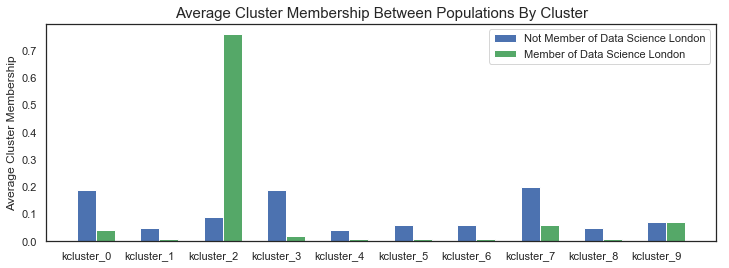

In [145]:
# Plot average cluster membership between populations by cluster to see which clusters are likely to be informative
cluster_means = prediction_df.groupby('member_of_group').mean().transpose().round(2).loc[
    prediction_df.columns.str.contains('kcluster'),:]

plt.figure(figsize=(12, 4))
width = 0.3

plt.bar(np.array(range(n_clusters)),cluster_means[0].values,width=width, color='b')
plt.bar(np.array(range(n_clusters))+width,cluster_means[1].values,width=width, color = 'g')
plt.xticks(np.array(range(n_clusters)), cluster_means.index);
plt.ylabel('Average Cluster Membership')
plt.title('Average Cluster Membership Between Populations By Cluster',size=15);
plt.legend(['Not Member of Data Science London', 'Member of Data Science London']);

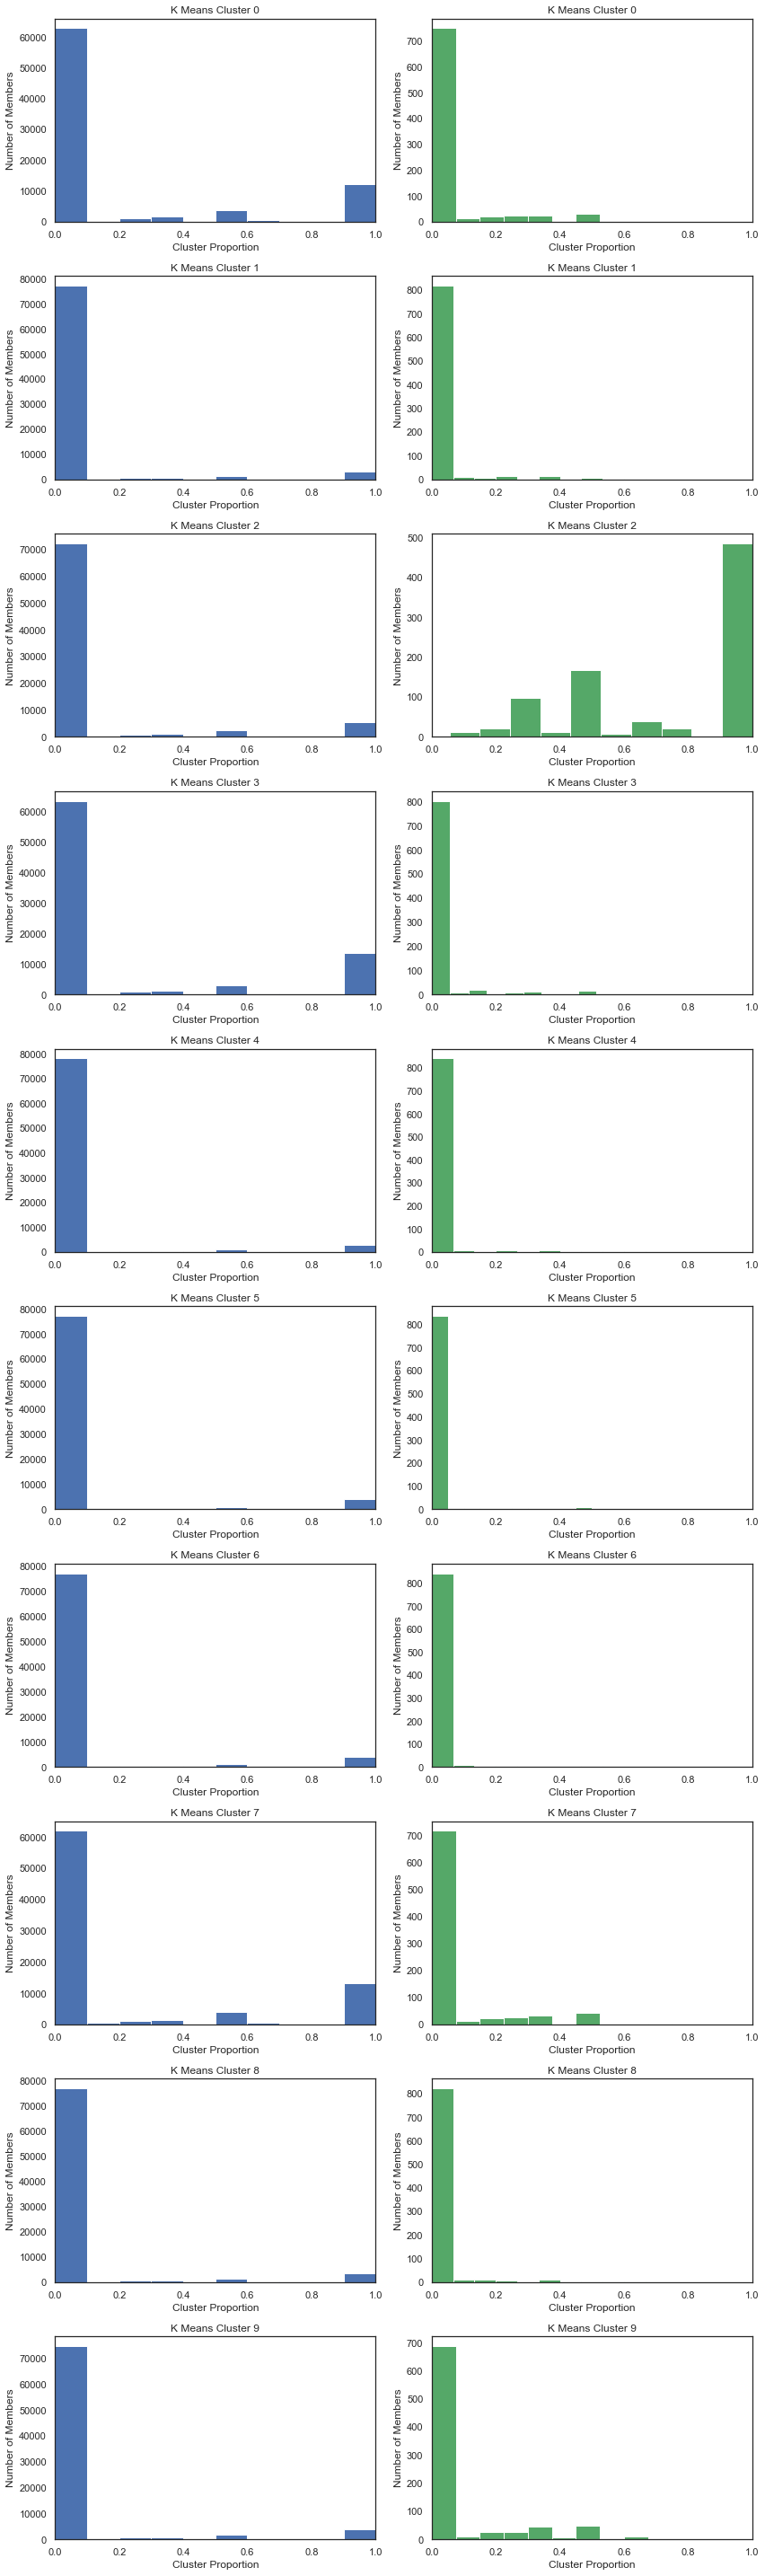

In [146]:
columns = 2
rows = n_clusters
fig = plt.figure(figsize=(12, 4*rows))

j = 0

for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)

    if i % 2 == 0:
        plt.hist(prediction_df['kcluster_'+str(j)].loc[prediction_df['member_of_group']==0]);
        plt.title('K Means Cluster '+str(j))
        plt.xlabel('Cluster Proportion')
        plt.ylabel('Number of Members')
        plt.xlim(0.0,1.0)

    else:
        plt.hist(prediction_df['kcluster_'+str(j)].loc[prediction_df['member_of_group']==1],color='g');
        plt.title('K Means Cluster '+str(j))
        plt.xlabel('Cluster Proportion')
        plt.ylabel('Number of Members')
        plt.xlim(0.0,1.0)
        
        j += 1

plt.tight_layout()
plt.show()


In [ ]:
sns.pairplot(prediction_df[prediction_df.columns[5:16]].iloc[:10000], hue='member_of_group');

In [147]:
node_data = pd.read_csv('projected_graph_nodelist.csv')

In [148]:
node_data.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
member_count,1457.0,875.36,1465.35,51.00,157.00,389.00,951.00,16000.00
node_size,1457.0,3.85,4.79,0.26,0.78,1.94,4.76,20.00
kcluster,1457.0,3.32,2.72,0.00,1.00,3.00,5.00,9.00
degree_centrality,1457.0,20.21,12.53,1.38,12.26,17.78,24.52,100.21
rel_closeness_centrality,1457.0,-0.00,0.14,-0.35,-0.11,0.01,0.11,0.25


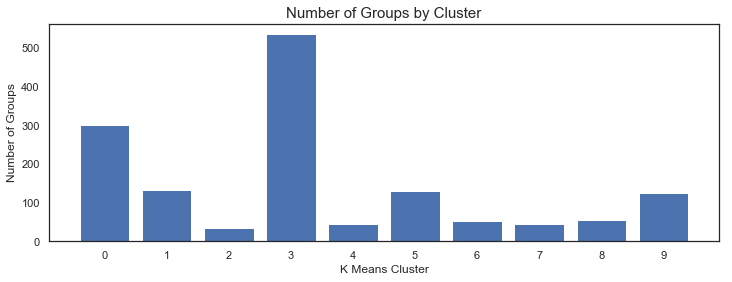

In [162]:
plt.figure(figsize=(12, 4))
plt.bar(node_data['kcluster'].value_counts().index, node_data['kcluster'].value_counts());
plt.xticks(node_data['kcluster'].value_counts().index);
plt.xlabel('K Means Cluster');
plt.ylabel('Number of Groups');
plt.title('Number of Groups by Cluster',size=15);

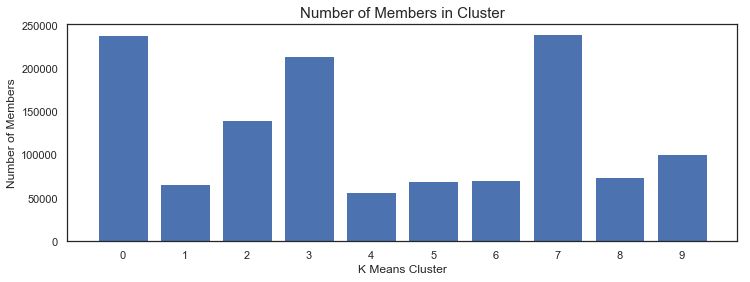

In [163]:
plt.figure(figsize=(12, 4))
plt.bar(range(10), node_data.groupby('kcluster').sum()['member_count'].values);
plt.xticks(node_data['kcluster'].value_counts().index);
plt.xlabel('K Means Cluster');
plt.ylabel('Number of Members');
plt.title('Number of Members in Cluster',size=15);

In [180]:
# Examine the loner dataframe and group charactertistics
loner_df = pd.read_csv('loner_df.csv')
loner_df.set_index('group_name',inplace=True)
loner_dict = dict(loner_df.sort_values('prop_loners',ascending=False)['prop_loners'])

node_data['prop_loners'] = [loner_dict[group] if group in loner_df.index else 0 for group in node_data['group_name'].values]

In [277]:
group_list = pd.read_csv('group_list.csv')
group_list = group_list[['urlname','created']] 
group_list.rename(columns={'urlname':'group_name'},inplace=True)

group_list['n_years'] = [(datetime(2018,12,5) - datetime.fromtimestamp(group_list['created'].iloc[i]/1000)).days / 365
                                for i in range(len(group_list))]

node_data = pd.merge(node_data, group_list[['group_name','n_years']], on='group_name', how='left')

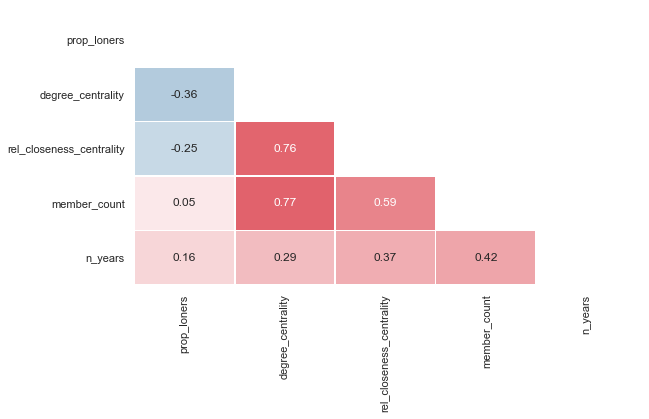

In [278]:
# Create correlation heatmap of important features and target
    # [https://seaborn.pydata.org/examples/many_pairwise_correlations.html]
sns.set(style="white")
corr_feats = node_data[['prop_loners','degree_centrality','rel_closeness_centrality','member_count','n_years']]

# Compute the correlation matrix
corr = corr_feats.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=False, linewidths=.5, annot=True, fmt=".2f", cbar=False, yticklabels = True, xticklabels = True);

# Modelling

In [164]:
from sklearn.model_selection import train_test_split

# Create function to split data into training and test by desired proportion
def initialize_train_test(target, test_proportion):
    y = prediction_df[target].copy()
    X = prediction_df.loc[:,prediction_df.columns !=target].copy()
    return train_test_split(X, y, test_size = test_proportion, random_state = 34)

In [165]:
from sklearn.preprocessing import StandardScaler

# Standardize the data, only applies to values exceeding 1 
# The vast majority are binary and therefore do not require standardization
def standardize(X_train_input, X_test_input):
    std_cols = X_train_input.columns[X_train_input.max() > 1]

    #Standardize features which require it in 'std_cols'
    sc = StandardScaler()

    std_train_df = X_train_input.loc[:,std_cols]
    std_test_df = X_test_input.loc[:,std_cols]

    sc.fit(std_train_df)

    X_train_input.loc[:,std_cols] = sc.transform(std_train_df)
    X_test_input.loc[:,std_cols] = sc.transform(std_test_df)

In [166]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Apply LightGBM model with optional gridsearch hyperparameter tuning
# Returns key evaluation metrics
def light_gbm(X_train_input, y_train_input, X_test_input, y_test_input,
              gridsearch = 'No', num_leaves=15, n_estimators=250):

    if gridsearch == 'Yes':

        parameters = {'num_leaves':[5,15,30,60,90]}

        lgbm = lgb.LGBMClassifier(num_leaves=num_leaves, n_estimators=250, objective='binary', random_state=34)
        clf = GridSearchCV(lgbm, parameters).fit(X_train_input,y_train_input.values.ravel())
        print ("Best Parameters:", clf.best_params_)

        num_leaves = clf.best_params_['num_leaves']

    else:
        num_leaves = num_leaves
        
    lgbm_clf = lgb.LGBMClassifier(num_leaves=num_leaves, n_estimators=250, objective='binary',
                                  random_state=34).fit(X_train_input,y_train_input.values.ravel())
    lgbm_predictedValue = lgbm_clf.predict_proba(X_test_input)

    y_pred = lgbm_predictedValue[:,1]
    lgbm_train_pred = lgbm_clf.predict(X_train_input)
    lgbm_test_pred = lgbm_clf.predict(X_test_input)
    
    AUC = roc_auc_score(y_test_input, y_pred)
    train_accuracy = lgbm_clf.score(X_train_input, y_train_input) 
    test_accuracy = lgbm_clf.score(X_test_input, y_test_input)
    
    lgbm_feature_importance = lgbm_clf.feature_importances_
    
    return AUC, train_accuracy, test_accuracy, lgbm_predictedValue, lgbm_test_pred, lgbm_feature_importance, lgbm_clf

In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score


# Apply logistic regression model with optional gridsearch hyperparameter tuning
# Returns key evaluation metrics
def logistic_regression(X_train_input, y_train_input, X_test_input, y_test_input,
                        gridsearch = 'No', C=1):

    if gridsearch == 'Yes':

        parameters = {'C':[0.01,0.1,1,10,100]}

        clf = GridSearchCV(LogisticRegression(C=1), parameters).fit(X_train_input,y_train_input.values.ravel())
        print ("Best Parameters:", clf.best_params_)

        C = clf.best_params_['C']

    else:
        C = C

    logr_clf = LogisticRegression(C=C).fit(X_train_input, y_train_input)
    logr_predictedValue = logr_clf.predict_proba(X_test_input)

    y_pred = logr_predictedValue[:,1]
    logr_train_pred = logr_clf.predict(X_train_input)
    logr_test_pred = logr_clf.predict(X_test_input)
    
    AUC = roc_auc_score(y_test_input, y_pred)
    train_accuracy = logr_clf.score(X_train_input, y_train_input) 
    test_accuracy = logr_clf.score(X_test_input, y_test_input)
    
    return AUC, train_accuracy, test_accuracy, logr_predictedValue, logr_test_pred, logr_clf

In [168]:
# Apply pipeline to data 
target = 'member_of_group'
X_train, X_test, y_train, y_test = initialize_train_test(target, 0.30)

standardize(X_train, X_test)

lgbm_AUC, lgbm_train_acc, lgbm_test_acc, lgbm_probs, lgbm_test_preds, lgbm_feature_importance, lgbm_clf = light_gbm(
    X_train, y_train, X_test, y_test, gridsearch = 'Yes')

logr_AUC, logr_train_acc, logr_test_acc, logr_probs, logr_test_preds, logr_clf = logistic_regression(
        X_train, y_train, X_test, y_test, gridsearch = 'Yes')

Best Parameters: {'num_leaves': 5}
Best Parameters: {'C': 0.01}


In [169]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Create function to find the optimal prediction cutoff threshold given the beta for classification
def find_opt_threshold(model_probs, y_test_input, max_threshold=0.20, f_beta=10):
    cutoff_thresholds = np.linspace(.01, max_threshold, 100)
    
    f_score_performance = np.zeros([len(cutoff_thresholds),2])

    for idx, threshold in enumerate(cutoff_thresholds):
        test_preds = np.where(model_probs>threshold, 1, 0)
        precision = precision_score(y_test, test_preds)
        recall = recall_score(y_test, test_preds)

        if precision == 0:
            break

        else:
            f_score = (1+f_beta)*((precision*recall)/((f_beta*precision)+recall))
            f_score_performance[idx] = [threshold, f_score]

    threshold = f_score_performance[np.argmax(f_score_performance[:,1])][0]
    return threshold


In [170]:
# Set beta parameter (the higher the more emphasis is placed on recall)
f_beta=10

# Apply thresholds for both models to get classification predictions
lgbm_threshold = find_opt_threshold(lgbm_probs[:,1], y_test, 0.2, f_beta)
lgbm_test_preds = np.where(lgbm_probs[:,1]>lgbm_threshold,1,0)

logr_threshold = find_opt_threshold(logr_probs[:,1], y_test, 0.2, f_beta)
logr_test_preds = np.where(logr_probs[:,1]>logr_threshold,1,0)

In [171]:
from sklearn.dummy import DummyClassifier

# Examine confusion matrices for both models and performance metrics
model_names = ['Light GBM','Logistic Regression']
model_predictions = [lgbm_test_preds, logr_test_preds]
model_AUC = [lgbm_AUC, logr_AUC]

for i in zip(model_names, model_predictions, model_AUC):
    print(i[0],'Model Evaluation:')
    print('Accuracy: {:.4f}'.format(accuracy_score(y_test, i[1])))
    print('AUC: {:.4f}'.format(i[2]))
    
    precision = precision_score(y_test, i[1])
    print('Precision: {:.4f}'.format(precision))
    
    recall = recall_score(y_test, i[1])
    print('Recall: {:.4f}'.format(recall))
    print('F-score (Beta: {:.0f}): {:.4f}'.format(f_beta, (1+f_beta)*((precision*recall)/((f_beta*precision)+recall))))
    print()

    print('Confusion Matrix:')
    print(pd.crosstab(y_test, i[1], rownames=['True'], colnames=['Predicted'], margins=True))
    print()
    
# Establish baseline with majority dummy classifier
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)

print('Accuracy of Majority classifier on test set: {:.4f}'
     .format(dummy_majority.score(X_test, y_test)))

Light GBM Model Evaluation:
Accuracy: 0.9379
AUC: 0.9656
Precision: 0.1177
Recall: 0.7913
F-score (Beta: 10): 0.5205

Confusion Matrix:
Predicted      0     1    All
True                         
0          23370  1507  24877
1             53   201    254
All        23423  1708  25131

Logistic Regression Model Evaluation:
Accuracy: 0.9007
AUC: 0.9536
Precision: 0.0814
Recall: 0.8583
F-score (Beta: 10): 0.4596

Confusion Matrix:
Predicted      0     1    All
True                         
0          22417  2460  24877
1             36   218    254
All        22453  2678  25131

Accuracy of Majority classifier on test set: 0.9899


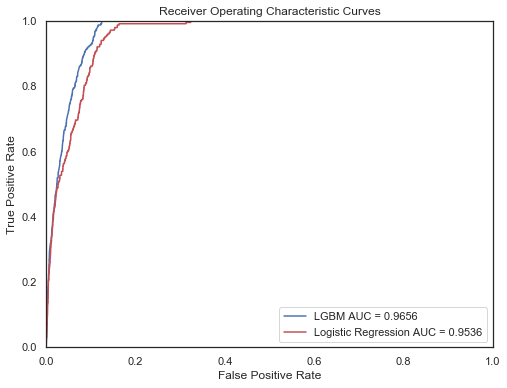

In [172]:
from sklearn import metrics

# Examine ROC curve for both models
lgbm_fpr, lgbm_tpr, _ = metrics.roc_curve(y_test, lgbm_probs[:,1])
logr_fpr, logr_tpr, _ = metrics.roc_curve(y_test, logr_probs[:,1])

plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic Curves')
plt.plot(lgbm_fpr, lgbm_tpr, 'b', label = 'LGBM AUC = %0.4f' % lgbm_AUC)
plt.plot(logr_fpr, logr_tpr, 'r', label = 'Logistic Regression AUC = %0.4f' % logr_AUC)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [173]:
# Examine feature importance from LightGBM
important_features = pd.DataFrame(lgbm_feature_importance, 
                              columns=["importance"],
                              index = X_train.columns)
important_features.sort_values(by='importance',ascending=False,inplace=True)
important_features[:20]

,importance
member_duration,364
kcluster_2,157
kcluster_7,73
num_groups,63
kcluster_9,58
kcluster_6,57
kcluster_3,42
kcluster_0,36
kcluster_8,33
kcluster_1,30


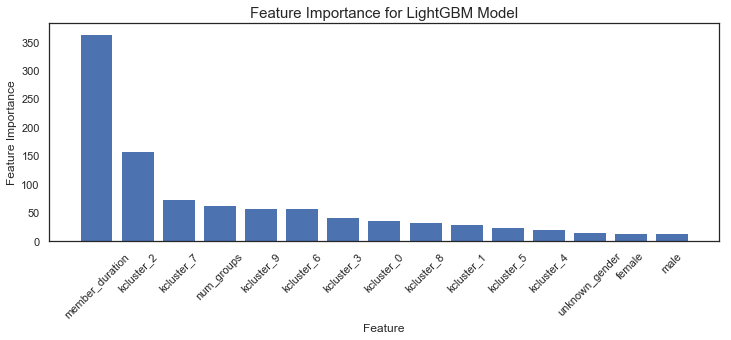

In [190]:
plt.figure(figsize=(12, 4))
plt.bar(range(len(important_features)), important_features['importance'].values);
plt.xticks(range(len(important_features)),important_features.index, rotation=45);
plt.xlabel('Feature');
plt.ylabel('Feature Importance');
plt.title('Feature Importance for LightGBM Model',size=15);

In [191]:
full_dataset = pd.concat([X_train, X_test])
full_dataset['lgbm_member_prob'] = lgbm_clf.predict_proba(full_dataset)[:,1]
full_dataset['logr_member_prob'] = logr_clf.predict_proba(full_dataset.drop('lgbm_member_prob',axis=1))[:,1]

full_dataset['member_of_group'] = pd.concat([y_train, y_test])

In [192]:
lgbm_predicted_members = full_dataset.loc[full_dataset['lgbm_member_prob']>=lgbm_threshold].sort_values(
    'lgbm_member_prob',ascending=False)

logr_predicted_members = full_dataset.loc[full_dataset['logr_member_prob']>=logr_threshold].sort_values(
    'logr_member_prob',ascending=False)

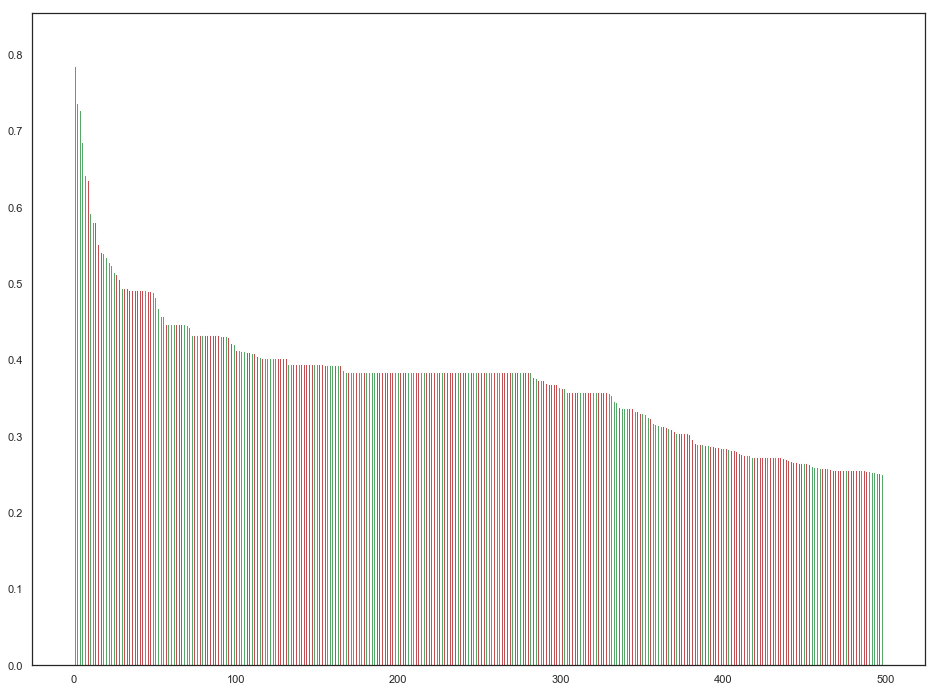

In [193]:
# Examine model predictions in terms of confidence and class membership for recommendationss
n_points = 500
color_mapping = ['g' if member else 'r' for member in  lgbm_predicted_members['member_of_group'].iloc[0:500].values]

plt.figure(figsize=(16, 12))
plt.bar(np.arange(n_points), list(lgbm_predicted_members['lgbm_member_prob'].iloc[0:500].values),width=1,color = color_mapping);

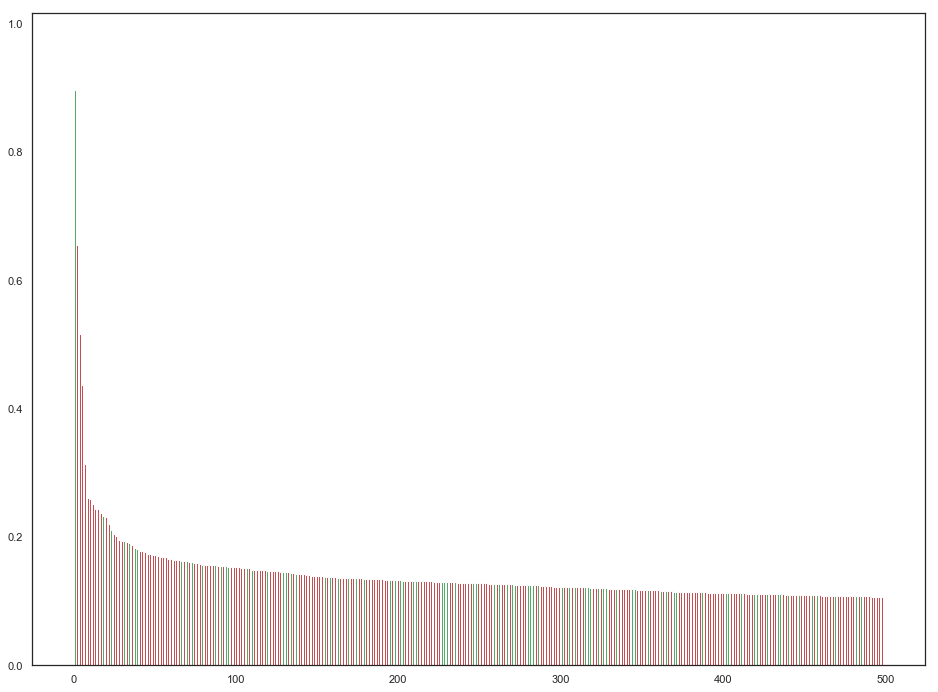

In [194]:
# Examine model predictions in terms of confidence and class membership for recommendationss
n_points = 500
color_mapping = ['g' if member else 'r' for member in  logr_predicted_members['member_of_group'].iloc[0:500].values]

plt.figure(figsize=(16, 12))
plt.bar(np.arange(n_points), list(logr_predicted_members['logr_member_prob'].iloc[0:500].values), width=1, color = color_mapping);

In [195]:
# Proportion of members predicted by lgbm
print(sum(lgbm_predicted_members['member_of_group'])/sum(full_dataset['member_of_group']))

# Proportion of members predicted
print(len(lgbm_predicted_members) / len(full_dataset))

# Correlation coefficient of predictions with actual
print(np.corrcoef(lgbm_predicted_members['lgbm_member_prob'],lgbm_predicted_members['member_of_group'])[0,1])

0.8715277777777778
0.06841596332684709
0.32571302457935647


In [196]:
# Proportion of members predicted by logr
print(sum(logr_predicted_members['member_of_group'])/sum(full_dataset['member_of_group']))

# Proportion of members predicted
print(len(logr_predicted_members) / len(full_dataset))

# Correlation coefficient of predictions with actual
print(np.corrcoef(logr_predicted_members['logr_member_prob'],logr_predicted_members['member_of_group'])[0,1])

0.8530092592592593
0.1056860100039395
0.17092498402516826


In [369]:
len(set(lgbm_predicted_members[lgbm_predicted_members['member_of_group'] == 0].index) & set(logr_predicted_members[logr_predicted_members['member_of_group'] == 0].index))

5308

In [376]:
# Proportion of members which overlap with logistic regression predicted members
5308/len(lgbm_predicted_members[lgbm_predicted_members['member_of_group'] == 0])

0.8436109345200254

# Predicting Group Size Based on Growth Trajectory

In [3]:
df = pd.read_csv('cons_member_list.csv')

In [4]:
member_df = df.copy()
member_df = member_df[['id','group_name','joined']]

In [5]:
member_df.head()

,id,group_name,joined
0,82088162.0,virtualJUG,1.508173e+12
1,212800896.0,virtualJUG,1.473697e+12
2,192767227.0,virtualJUG,1.461686e+12
3,13398759.0,virtualJUG,1.409211e+12
4,65852082.0,virtualJUG,1.390833e+12


In [6]:
member_df.dropna(subset=['joined'],axis=0,inplace=True)

In [7]:
from datetime import datetime
member_df['datetime_objects'] = [datetime.fromtimestamp(joined/1000) for joined in member_df['joined']]

In [8]:
# Import data for convenience
node_data = pd.read_csv('projected_graph_nodelist.csv')
group_list = pd.read_csv('group_list.csv')
group_list = group_list[['urlname','created']]

# Set number of months of training data and number of years out to test
num_months = 12
num_years = 2

In [9]:
# Get number of years group has existed for 
group_list['years'] = np.array([(datetime(2018,12,5) - datetime.fromtimestamp(group_list['created'].iloc[i]/1000)).days / 365
                                for i in range(len(group_list))])

# Get group names which have existed for more than 2 years and are included in subset with member information
timeseries_groups = [group for group in group_list['urlname'].loc[group_list['years'] > num_years].values 
                     if group in node_data['group_name'].values]

In [10]:
from dateutil.relativedelta import relativedelta

# Instantiate growth dataframe
group_growth_df = pd.DataFrame(timeseries_groups,columns=['group_name'])

# Instantiate array for speed
group_growth_array = np.zeros([len(group_growth_df),num_months+1])

# Run loop which goes through groups and finds member count at given increment
for idx, group in enumerate(timeseries_groups):
    temp_group = member_df[member_df['group_name'] == group]

    start_date = min(temp_group['datetime_objects'])
    end_date = start_date + relativedelta(years=num_years)

    monthly_member_count = [len(temp_group[temp_group['datetime_objects'] <=  start_date + relativedelta(months=i)])
                            for i in range(num_months)]
    ending_member_count = len(temp_group[temp_group['datetime_objects'] <=  end_date])

    monthly_member_count.append(ending_member_count)
    
    group_growth_array[idx] = monthly_member_count

In [11]:
growth_values = pd.DataFrame(group_growth_array).pct_change(axis=1).iloc[:,2:]
group_growth_df = group_growth_df.join(growth_values)

In [12]:
group_growth_df['m1_member_count'] = group_growth_array[:,1]
group_growth_df['m12_member_count'] = group_growth_array[:,-2]
group_growth_df.rename({12:'target_growth_rate'},axis=1,inplace=True)

In [13]:
group_growth_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
2,827.0,0.861171,8.764506,0.0,0.116612,0.279070,0.500000,240.000000
3,827.0,0.258650,0.302420,0.0,0.086957,0.192857,0.326144,3.125000
4,827.0,0.186605,0.217775,0.0,0.065076,0.141892,0.232071,3.500000
5,827.0,0.147965,0.289640,0.0,0.051968,0.111111,0.196575,7.307692
6,827.0,0.127786,0.143401,0.0,0.041667,0.095238,0.168885,1.708333
7,827.0,0.112901,0.176013,0.0,0.030536,0.075718,0.146540,3.225225
8,827.0,0.101696,0.156964,0.0,0.031587,0.074627,0.126211,2.717647
9,827.0,0.084895,0.087770,0.0,0.026316,0.065625,0.113759,1.000000
10,827.0,0.087714,0.123828,0.0,0.024948,0.060302,0.108531,1.857143
11,827.0,0.076146,0.136155,0.0,0.022100,0.051282,0.097006,3.142857


In [14]:
group_growth_df['target_growth_rate'] = np.where(group_growth_df['target_growth_rate'] > 1,1,0)

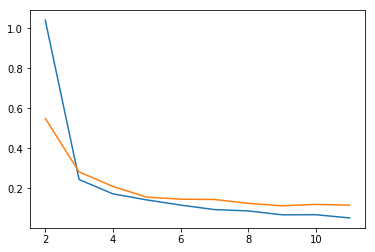

In [15]:
plt.plot(group_growth_df.groupby(['target_growth_rate']).mean().iloc[:,:10].transpose());

In [175]:
prediction_df = group_growth_df.copy()
prediction_df.drop(['group_name'],axis=1,inplace=True)

In [176]:
X_train, X_test, y_train, y_test = initialize_train_test('target_growth_rate', 0.30)

standardize(X_train, X_test)

lgbm_AUC, lgbm_train_acc, lgbm_test_acc, lgbm_probs, lgbm_test_preds, lgbm_feature_importance, lgbm_clf = light_gbm(
    X_train, y_train, X_test, y_test, gridsearch = 'No', num_leaves=5)

logr_AUC, logr_train_acc, logr_test_acc, logr_probs, logr_test_preds, logr_clf = logistic_regression(
        X_train, y_train, X_test, y_test, gridsearch = 'No')

print('LightGBM Accuracy: {:.4f}'.format(lgbm_test_acc))
print('Logistic Regression Accuracy: {:.4f}'.format(logr_test_acc))

LightGBM Accuracy: 0.7068
Logistic Regression Accuracy: 0.6948


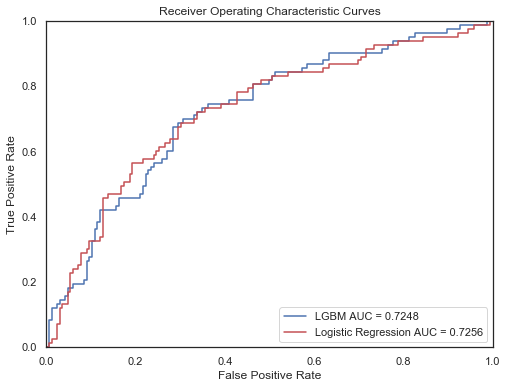

In [177]:
from sklearn import metrics

# Examine ROC curve for both models
lgbm_fpr, lgbm_tpr, _ = metrics.roc_curve(y_test, lgbm_probs[:,1])
logr_fpr, logr_tpr, _ = metrics.roc_curve(y_test, logr_probs[:,1])

plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic Curves')
plt.plot(lgbm_fpr, lgbm_tpr, 'b', label = 'LGBM AUC = %0.4f' % lgbm_AUC)
plt.plot(logr_fpr, logr_tpr, 'r', label = 'Logistic Regression AUC = %0.4f' % logr_AUC)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

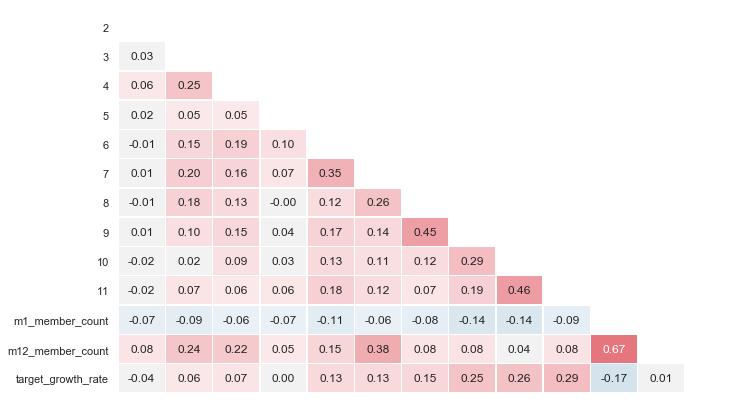

In [178]:
# Create correlation heatmap of important features and target
    # [https://seaborn.pydata.org/examples/many_pairwise_correlations.html]
sns.set(style="white")
corr_feats = pd.concat([X_train, y_train],axis=1)

# Compute the correlation matrix
corr = corr_feats.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=False, linewidths=.5, annot=True, fmt=".2f", cbar=False, yticklabels = True, xticklabels = False);


Number of Groups in Cluster:


2    262
0    190
4     76
1     19
3     18
Name: kcluster, dtype: int64

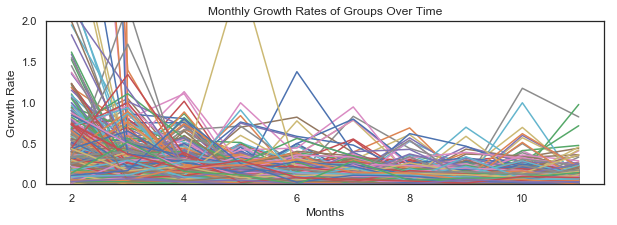

In [179]:
plt.figure(figsize=(10, 3))
plt.plot(kmeans_chart.iloc[:,:-1].transpose());
plt.title('Monthly Growth Rates of Groups Over Time')
plt.xlabel('Months')
plt.ylabel('Growth Rate')
plt.ylim(0,2);

print('Number of Groups in Cluster:')
kmeans_chart['kcluster'].value_counts()

In [180]:
n_clusters = 5

Number of Groups in Cluster:


0    317
3    170
4     79
2     11
1      1
Name: kcluster, dtype: int64

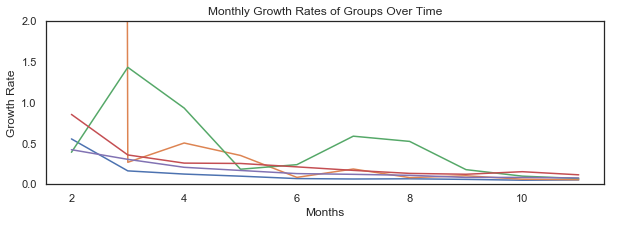

In [181]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=34).fit(X_train)

kmeans_chart = prediction_df.loc[X_train.index].iloc[:,:10].copy()
kmeans_chart['kcluster'] = kmeans.predict(X_train)

plt.figure(figsize=(10, 3))
plt.plot(kmeans_chart.groupby('kcluster').mean().transpose());
plt.title('Monthly Growth Rates of Groups Over Time')
plt.xlabel('Months')
plt.ylabel('Growth Rate')
plt.ylim(0,2);

print('Number of Groups in Cluster:')
kmeans_chart['kcluster'].value_counts()

In [182]:
outlier_values = kmeans_chart[(kmeans_chart['kcluster'] == 1) | (kmeans_chart['kcluster'] == 2)].index
X_train.drop(outlier_values,axis=0,inplace=True)
y_train.drop(outlier_values,axis=0,inplace=True)

Number of Groups in Cluster:


0    298
1    174
2     74
3     19
4      1
Name: kcluster, dtype: int64

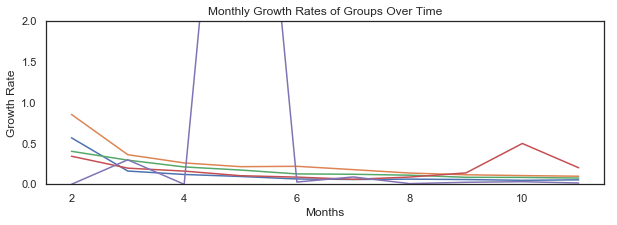

In [183]:
kmeans = KMeans(n_clusters=n_clusters, random_state=34).fit(X_train)

kmeans_chart = prediction_df.loc[X_train.index].iloc[:,:10].copy()
kmeans_chart['kcluster'] = kmeans.predict(X_train)

plt.figure(figsize=(10, 3))
plt.plot(kmeans_chart.groupby('kcluster').mean().transpose());
plt.title('Monthly Growth Rates of Groups Over Time')
plt.xlabel('Months')
plt.ylabel('Growth Rate')
plt.ylim(0,2);

print('Number of Groups in Cluster:')
kmeans_chart['kcluster'].value_counts()

In [184]:
outlier_values = kmeans_chart[(kmeans_chart['kcluster'] == 4)].index
X_train.drop(outlier_values,axis=0,inplace=True)
y_train.drop(outlier_values,axis=0,inplace=True)

Number of Groups in Cluster:


2    262
0    190
4     76
1     19
3     18
Name: kcluster, dtype: int64

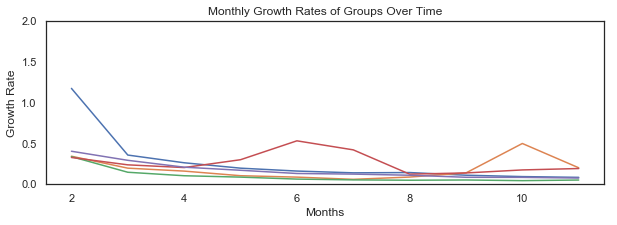

In [185]:
kmeans = KMeans(n_clusters=n_clusters, random_state=34).fit(X_train)

kmeans_chart = prediction_df.loc[X_train.index].iloc[:,:10].copy()
kmeans_chart['kcluster'] = kmeans.predict(X_train)

plt.figure(figsize=(10, 3))
plt.plot(kmeans_chart.groupby('kcluster').mean().transpose());
plt.title('Monthly Growth Rates of Groups Over Time')
plt.xlabel('Months')
plt.ylabel('Growth Rate')
plt.ylim(0,2);

print('Number of Groups in Cluster:')
kmeans_chart['kcluster'].value_counts()

In [186]:
lgbm_AUC, lgbm_train_acc, lgbm_test_acc, lgbm_probs, lgbm_test_preds, lgbm_feature_importance, lgbm_clf = light_gbm(
    X_train, y_train, X_test, y_test, gridsearch = 'No', num_leaves=5)

logr_AUC, logr_train_acc, logr_test_acc, logr_probs, logr_test_preds, logr_clf = logistic_regression(
        X_train, y_train, X_test, y_test, gridsearch = 'No')

print('LightGBM Accuracy: {:.4f}'.format(lgbm_test_acc))
print('Logistic Regression Accuracy: {:.4f}'.format(logr_test_acc))

LightGBM Accuracy: 0.6908
Logistic Regression Accuracy: 0.7189


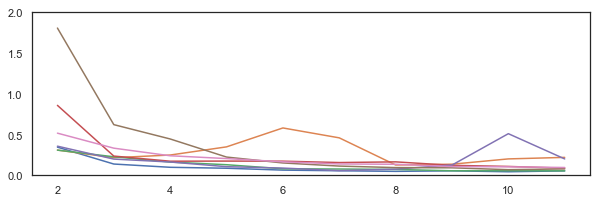

In [187]:
n_clusters=3

kmeans = KMeans(n_clusters, random_state=34).fit(X_train)

plt.figure(figsize=(10, 3))
kmeans_chart = prediction_df.loc[X_train.index].iloc[:,:10].copy()
kmeans_chart['kcluster'] = kmeans.predict(X_train)

plt.plot(kmeans_chart.groupby('kcluster').mean().transpose());
plt.ylim(0,2);

In [188]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=34).fit(X_train)

train_kmeans_df = pd.get_dummies(kmeans.predict(X_train))
train_kmeans_df.columns = ['kcluster_'+str(i) for i in range(n_clusters)]
train_kmeans_df.index = X_train.index
X_train = X_train.join(train_kmeans_df)

test_kmeans_df = pd.get_dummies(kmeans.predict(X_test))
missing_clusters = list(set([int(col[-1]) for col in train_kmeans_df.columns]) - set(kmeans.predict(X_test)))
for col in missing_clusters:
    test_kmeans_df[col]=0
test_kmeans_df.columns = ['kcluster_'+str(i) for i in range(n_clusters)]
test_kmeans_df.index = X_test.index
X_test = X_test.join(test_kmeans_df)

In [189]:
lgbm_AUC, lgbm_train_acc, lgbm_test_acc, lgbm_probs, lgbm_test_preds, lgbm_feature_importance, lgbm_clf = light_gbm(
    X_train, y_train, X_test, y_test, gridsearch = 'No', num_leaves=5)

logr_AUC, logr_train_acc, logr_test_acc, logr_probs, logr_test_preds, logr_clf = logistic_regression(
        X_train, y_train, X_test, y_test, gridsearch = 'No')

print('LightGBM Accuracy: {:.4f}'.format(lgbm_test_acc))
print('Logistic Regression Accuracy: {:.4f}'.format(logr_test_acc))

LightGBM Accuracy: 0.7028
Logistic Regression Accuracy: 0.7229


In [138]:
kmeans_lookup = node_data[['group_name','kcluster']]
kmeans_lookup.set_index('group_name',inplace=True);

X_train['group_kcluster'] = [kmeans_lookup.loc[group].item() for group in group_growth_df['group_name'].loc[X_train.index].values]
X_test['group_kcluster'] = [kmeans_lookup.loc[group].item() for group in group_growth_df['group_name'].loc[X_test.index].values]

In [139]:
mean_encodings = pd.concat([X_train['group_kcluster'], y_train], axis=1).groupby('group_kcluster').mean()
X_train['group_kcluster'] = [mean_encodings.loc[cluster].item() for cluster in X_train['group_kcluster']]
X_test['group_kcluster'] = [mean_encodings.loc[cluster].item() for cluster in X_test['group_kcluster']]

In [140]:
lgbm_AUC, lgbm_train_acc, lgbm_test_acc, lgbm_probs, lgbm_test_preds, lgbm_feature_importance, lgbm_clf = light_gbm(
    X_train, y_train, X_test, y_test, gridsearch = 'No', num_leaves=5)

logr_AUC, logr_train_acc, logr_test_acc, logr_probs, logr_test_preds, logr_clf = logistic_regression(
        X_train, y_train, X_test, y_test, gridsearch = 'No')

print('LightGBM Accuracy: {:.4f}'.format(lgbm_test_acc))
print('Logistic Regression Accuracy: {:.4f}'.format(logr_test_acc))

LightGBM Accuracy: 0.7430
Logistic Regression Accuracy: 0.7430


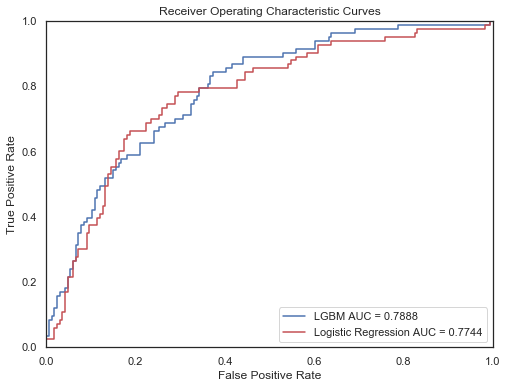

In [141]:
from sklearn import metrics

# Examine ROC curve for both models
lgbm_fpr, lgbm_tpr, _ = metrics.roc_curve(y_test, lgbm_probs[:,1])
logr_fpr, logr_tpr, _ = metrics.roc_curve(y_test, logr_probs[:,1])

plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic Curves')
plt.plot(lgbm_fpr, lgbm_tpr, 'b', label = 'LGBM AUC = %0.4f' % lgbm_AUC)
plt.plot(logr_fpr, logr_tpr, 'r', label = 'Logistic Regression AUC = %0.4f' % logr_AUC)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [316]:
group_clusters = pd.get_dummies(X_train['group_kcluster'])
group_clusters.columns = ['group_kcluster_'+str(i) for i in range(len(group_clusters.columns))]

X_train = X_train.join(group_clusters)
X_train.drop('group_kcluster',axis=1,inplace=True)

group_clusters = pd.get_dummies(X_test['group_kcluster'])
group_clusters.columns = ['group_kcluster_'+str(i) for i in range(len(group_clusters.columns))]

X_test = X_test.join(group_clusters)
X_test.drop('group_kcluster',axis=1,inplace=True)

In [248]:
test_df.groupby('target_growth_rate').mean()

,2,3,4,5,6,7,8,9,10,11,...,kcluster_0,kcluster_1,kcluster_2,kcluster_3,kcluster_4,kcluster_5,kcluster_6,kcluster_7,kcluster_8,kcluster_9
target_growth_rate,,,,,,,,,,,,,,,,,,,,,
0,1.041004,0.244689,0.173054,0.142848,0.116992,0.094412,0.087830,0.068414,0.068795,0.052793,...,0.311069,0.019084,0.015267,0.358779,0.036260,0.019084,0.040076,0.015267,0.034351,0.150763
1,0.550172,0.282793,0.210038,0.156815,0.146452,0.144875,0.125673,0.113398,0.120432,0.116532,...,0.247525,0.016502,0.082508,0.257426,0.056106,0.029703,0.052805,0.115512,0.066007,0.075908


In [11]:
# Analyze the predominant cluster membership of lone groups
node_data = pd.read_csv('projected_graph_nodelist.csv')

In [12]:
node_data.groupby('kcluster').mean()

,member_count,node_size,degree_centrality,rel_closeness_centrality
kcluster,,,,
0,793.092715,3.743891,21.581897,0.051509
1,495.924812,2.479624,18.651472,-0.013467
2,4125.235294,16.000735,59.209063,0.217918
3,400.414179,2.002071,10.967389,-0.093692
4,1295.886364,6.063068,23.566232,0.053267
5,541.130769,2.621308,20.955596,-0.009375
6,1347.320755,6.280943,20.365019,0.043445
7,5456.931818,17.123977,51.604665,0.215406
8,1355.109091,6.109091,31.146730,0.083478


In [13]:
node_data[node_data['group_name'] == 'London-Decent-bet-Meetup']

,group_name,member_count,node_size,node_color,kcluster,degree_centrality,rel_closeness_centrality
982,London-Decent-bet-Meetup,146,0.73,#ffbb78,3,7.230495,-0.194531


In [14]:
loner_df = pd.read_csv('loner_df.csv')

In [15]:
loner_df.sort_values('prop_loners',ascending=False).head(10).round(2)

,group_name,abs_loners,prop_loners
1,Jenkins-online-meetup,2401,0.87
0,virtualJUG,13451,0.84
355,Association-of-Coaches-Experts-and-speakers,117,0.77
737,LEAGUE-OF-BLOCKS-Quanta-s-world-tour-series,39,0.74
390,London-Workday-HRIS-Meetup,102,0.73
194,SND-London,229,0.71
258,Green-Gathering,170,0.69
114,meetup-group-mjSPBkre,356,0.66
411,London-Decent-bet-Meetup,96,0.66
687,Nintex_UserGroup_UK,47,0.65


In [16]:
# Majority loner groups
loner_df['group_name'].loc[loner_df['prop_loners']>.5].values

array(['virtualJUG', 'Jenkins-online-meetup', 'MinistryOfTesting',
       'Outlier_Ventures', 'Restarters-London', 'sug-uk',
       'Lets-talk-Data', 'Zappers-Software-Testing-Community',
       'Amazon-Sellers-London', 'meetup-group-mjSPBkre', 'CSM-london',
       'JUCE-Meetup', 'blockchain_world_events', 'virtualfutures',
       'Social-Gambling', 'SND-London', 'Linnworks-eBay-Amazon-Beyond',
       'London-Email-Meetup', 'London-Podcasting-Community',
       'edX-London-Community', 'Green-Gathering',
       'Mozilla-Developer-Network', 'Construction-Blockchain',
       'Association-of-Coaches-Experts-and-speakers',
       'Liferay-UK-Meetup-Group', 'cmgrLDN', 'London-Workday-HRIS-Meetup',
       'Agile-In-Audit', 'Alfresco-Meetups', 'SilverStripeUK',
       'London-Decent-bet-Meetup', 'LondonDAM', 'Qlik-Dev-Group-London',
       'Make-Club-Make-your-ideas-happen-together', 'Lucee-Group',
       'Nexus-Earth', 'MainframerZ-London', 'Nintex_UserGroup_UK',
       'The-Travel-Bloggers-G

In [17]:
kmeans_lookup = node_data[['group_name','kcluster']]
kmeans_lookup.set_index('group_name',inplace=True);
loner_clusters = [kmeans_lookup.loc[group].item() for group in loner_df['group_name'].loc[loner_df['prop_loners']>.5].values]


In [25]:
Counter(loner_clusters)

Counter({0: 1, 3: 37, 1: 1, 5: 1})

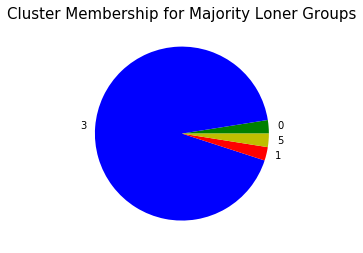

In [28]:
from collections import Counter
plt.figure(figsize=(6, 4))
plt.pie([value for value in Counter(loner_clusters).values()],labels=[0,3,1,5],colors=['g','b','r','y']);
plt.title('Cluster Membership for Majority Loner Groups',size=15);